# 《2023类脑计算和类脑计算系统技术》ANN编程实验（二）
### by 林逸晗 邢毅诚 2023年10月14日

# 运行前准备

- 安装pytorch
- 安装tensorflow, keras
    - conda install tensorflow
    - conda install keras
    版本不限，我们只是需要它的数据接口
- 安装matplotlib
    - pip install matplotlib
    用来画图，版本不限
    
    
- 下载[imdb.npz](https://www.kaggle.com/datasets/vikramtiwari/imdb-dataset-for-keras-imdbnpz)，放置在notebook同路径下（如果不在服务器上运行，可以跳过此步骤，会自动下载）
- 直接在jupyter内运行下面的bash命令
- 如果在服务器上运行，请把以下的所有"cuda:0"，都改成"cuda:x"，x为给你分配的组号

本代码修改自[github仓库:Pytorch-imdb-classification](https://github.com/Cong-Huang/Pytorch-imdb-classification)

In [20]:
#此部分代码用来下载数据集，如果不在服务器上跑，数据集可以自动下载，并不需要进行这几个操作，如果在后续操作中无法找到数据集的话，请手动在工程目录下创建model文件夹，并将下载后的imdb.npz放入/.keras/datasets文件夹。
!mkdir ~/.keras
!cp ./imdb.npz ~/.keras/datasets
!mkdir model

mkdir: cannot create directory ‘/home/student/.keras’: File exists
mkdir: cannot create directory ‘model’: File exists


In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import * 
from keras.preprocessing.sequence import pad_sequences 
from keras.datasets import imdb 
torch.__version__

'1.10.1'

# 注意力机制与多头注意力机制

### [原始论文:Attention Is All You Need,2017](https://arxiv.org/abs/1706.03762v5)


![attention.png](./figure/attention.png)
左图是单头注意力，右图是多头注意力


### 1. 为什么要有Attention:RNN和LSTM有什么问题？

Q: 依赖关系不一定是时序关系！全局依赖关系如何获得？

让我们从循环神经网络的老大难问题——机器翻译问题入手。我们知道，普通的用目标语言中的词语来代替原文中的对应词语是行不通的，因为从语言到另一种语言时词语的语序会发生变化。比如英语的“red”对应法语的“rouge”，英语的“dress”对应法语“robe”，但是英语的“red dress”对应法语的“robe rouge”。

为了解决这个问题，我们创造了Encoder-Decoder结构的循环神经网络。它先通过一个Encoder循环神经网络读入所有的待翻译句子中的单词，得到一个包含原文所有信息的中间隐藏层，接着把中间隐藏层状态输入Decoder网络，一个词一个词的输出翻译句子。这样子无论输入中的关键词语有着怎样的先后次序，由于都被打包到中间层一起输入后方网络，我们的Encoder-Decoder网络都可以很好地处理这些词的输出位置和形式了。

##### Q: 为什么注意力机制看似简单却这么晚才提出？

算力的发展使得这种稠密计算在GPU性能大幅跃升之后才能得以应用到DNN中

### 2. 注意力机制的公式化和理解


可以注意到输入是query、key、value三个矩阵，首先我们计算query与每个key的关联性（compatibility），之后将每个关联性作为每个value的权重（weight），各个权重与value的乘积相加得到输出，这就是注意力机制的基本方法论。


```
例：这里我们假定输入的Q、K、V三个张量的数据格式为：[batch_size, s_len, dim]，其中s_len表示输入的句子的长度，则每个单词都可以理解为dim维的向量，注意力就是希望每个单词的向量中都可以包含除了自身之外和其它单词（即上下文之间）的信息，所以我们先将Q与K做矩阵乘法QK^T ，这样我们就得到了一个[batch_size, s_len, s_len] 格式的输出，并对它做一次softmax，这样就得到了一个每个单词之间的关系的得分张量[batch_size, s_len, s_len] ，此时我们得到了各个单词与其它单词之间的关系分数，如果关系越密切，那么数值就应该越大，我们将这个矩阵与value矩阵相乘，就得到了最终的结果。
```

### 3. Attention 带来的算法改进

Attention显著地提高了翻译算法的表现。它可以很好地使Decoder网络注意原文中的某些重要区域来得到更好的翻译。

Attention解决了信息瓶颈问题。原先的Encoder-Decoder网络的中间状态只能存储有限的文本信息，现在它只需要完成如何分配注意力的任务即可。

Attention减轻了梯度消失问题。Attention在网络后方到前方建立了连接的捷径，使得梯度可以更好的传递。

Attention提供了一些可解释性。通过观察网络运行过程中产生的注意力的分布，我们可以知道网络在输出某句话时都把注意力集中在哪里；而且通过训练网络，我们还得到了一个免费的翻译词典（soft alignment）

# 单头注意力机制的实现（不加权）


- 请同学们按照下列公式，补充attention函数代码，并在已有数据上验证代码结果

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d}})*V$$

其中 Q，K，V是query、key、value，是[数据批次大小, 序列长度, 特征维度]的张量，d是特征维度

- **思考1**：QKV中，QKV一定要不同吗？
- **思考2**：为什么需要除以特征维度的平方根？
```
原文：We suspect that for large values of d_k , the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by d_k .
```
这一个解释是合理的吗？不去掉可以吗？
- **思考3**：softmax一定是最有道理的吗？可以用其他非线性函数吗？

- 可参考：
    - [知乎1](https://zhuanlan.zhihu.com/p/380892265)
    - [知乎2](https://zhuanlan.zhihu.com/p/611684065?utm_id=0)
    
结果应该如：
![output.png](./figure/output.png)

**在此处，请根据attention的定义完成attention函数**

p_attn size: torch.Size([1, 10, 10])


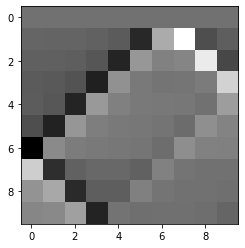

In [3]:
import math
import matplotlib.pyplot as plt

#### TODO：这里会作为第一个填空部分 ########
def attention(query, key, value, mask=None, dropout=None):
    """Compute 'Scaled Dot Product Attention'"""
    """Please write your code here"""


query  = torch.zeros([1,10,32])
key    = torch.zeros([1,10,32])
value  = torch.zeros([1,10,32])

for j in range(10):
    for i in range(32):
        query[0,j,i] = math.sin(i*j)
        key[0,j,i] = math.cos(i*j)
        value[0,j,i] = math.tan(i*j)

weighted_V,p_attn = attention(query, key, value, mask=None, dropout=None)

print('p_attn size:',p_attn.shape)

plt.imshow(p_attn[0,...],cmap='gray')
plt.show()

# 加权的注意力机制

- 实用中发现，纯靠这一个公式效果并不一定很好，太依赖于先验设计，因此可以把Q、k、V都映射到隐空间中，加权后进行注意力


$$Attention(Q,K,V) = softmax(\frac{QW_Q * (KW_K)^T}{\sqrt{d}})*VW_V $$

在这里，我们用一个pytorch的module来实现这样一个带权重，可学习的Attention module

**在此处，请根单头注意力的定义完成single_head_attention()函数**

p_attn size: torch.Size([1, 10, 10])


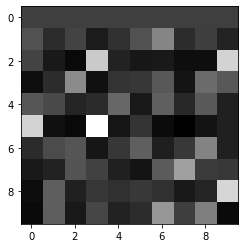

In [4]:
import math
import matplotlib.pyplot as plt

#### TODO：这里会作为第2个填空部分 ########
class single_head_attention(nn.Module):

    def __init__(self, feature_dim, hidden_dim, dropout):
        super(single_head_attention, self).__init__()
        self.wq = nn.Parameter(torch.randn(feature_dim,hidden_dim))
        self.wk = nn.Parameter(torch.randn(feature_dim,hidden_dim))
        self.wv = nn.Parameter(torch.randn(feature_dim,hidden_dim))
        
        #试试去掉以下三行初始化，看看会发生什么
        nn.init.xavier_uniform_(self.wq)
        nn.init.xavier_uniform_(self.wk)
        nn.init.xavier_uniform_(self.wv)

    def forward(self,query, key, value, mask=None, dropout=None):
        """Compute 'Scaled Dot Product Attention'"""
        """Please write your code here"""
        
sha = single_head_attention(32,16, dropout=None)

query  = torch.zeros([1,10,32])
key    = torch.zeros([1,10,32])
value  = torch.zeros([1,10,32])

for j in range(10):
    for i in range(32):
        query[0,j,i] = math.sin(i*j)
        key[0,j,i] = math.cos(i*j)
        value[0,j,i] = math.tan(i*j)

weighted_V,p_attn = sha(query, key, value, mask=None)

print('p_attn size:',p_attn.shape)

plt.imshow(p_attn[0,...].detach(),cmap='gray')
plt.show()

# 多头注意力机制的实现

- 单头注意力一次性要把所有的特征都进行点积，计算量上是不是有点太夸张了?
- 于是发展出了多头注意力机制，可作为参考
- [MTA deep_learning_implementations](https://github.com/laohuu/deep_learning_implementations/blob/main/algorithms/transformers/mha.py#)

# 实验：训练一个LSTM

# 注意力机制在LSTM上的作用

In [5]:
# baselineModel:LSTM
# 这个模型的准确率是87%左右
class LSTM_basic(nn.Module):
    def __init__(self, max_words, emb_size, hid_size, dropout):
        super(LSTM_basic, self).__init__()
        self.max_words = max_words
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.dropout = dropout
        self.Embedding = nn.Embedding(self.max_words, self.emb_size)
        self.LSTM = nn.LSTM(self.emb_size, self.hid_size, num_layers=2,
                            batch_first=True, bidirectional=True)   # 2层双向LSTM
        self.dp = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(self.hid_size*2, self.hid_size)
        self.fc2 = nn.Linear(self.hid_size, 2)
    
    def forward(self, x):
        """
        input : [bs, maxlen]
        output: [bs, 2] 
        """
        x = self.Embedding(x)  # [bs, ml, emb_size]
        x = self.dp(x)
        x, _ = self.LSTM(x)  # [bs, ml, 2*hid_size]
        x = self.dp(x)
        x = F.relu(self.fc1(x))   # [bs, ml, hid_size]
        x = F.avg_pool2d(x, (x.shape[1], 1)).squeeze()  # [bs, 1, hid_size] => [bs, hid_size]
        out = self.fc2(x)    # [bs, 2]
        return out  # [bs, 2]

class LSTM_Attention(nn.Module):
    def __init__(self, max_words, emb_size, hid_size, dropout):
        super(LSTM_Attention, self).__init__()
        self.max_words = max_words
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.dropout = dropout
        self.Embedding = nn.Embedding(self.max_words, self.emb_size)
        self.LSTM1 = nn.LSTM(self.emb_size, self.hid_size, num_layers=1,
                            batch_first=True, bidirectional=True)   # 2层双向LSTM
        self.attn = single_head_attention(2*hid_size,hid_size, dropout=None)
        self.LSTM2 = nn.LSTM(self.emb_size, self.hid_size, num_layers=1,
                            batch_first=True, bidirectional=True)   # 2层双向LSTM
        
        self.dp = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(self.hid_size*2, self.hid_size)
        self.fc2 = nn.Linear(self.hid_size, 2)
    
    def forward(self, x):
        """
        input : [bs, maxlen]
        output: [bs, 2] 
        """
        x = self.Embedding(x)  # [bs, ml, emb_size]
        x = self.dp(x)
        x, _ = self.LSTM1(x)  # [bs, ml, 2*hid_size]
        x,_ = self.attn(x,x,x)
        x, _ = self.LSTM2(x)  # [bs, ml, 2*hid_size]
        
        x = self.dp(x)
        x = F.relu(self.fc1(x))   # [bs, ml, hid_size]
        x = F.avg_pool2d(x, (x.shape[1], 1)).squeeze()  # [bs, 1, hid_size] => [bs, hid_size]
        out = self.fc2(x)    # [bs, 2]
        return out  # [bs, 2]

# 准备数据和训练流程

In [6]:
MAX_WORDS = 10000  # imdb’s vocab_size 即词汇表大小
MAX_LEN = 256      # max length
BATCH_SIZE = 256
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
(x_train, y_train), (x_test, y_test) = imdb.load_data("./imdb.npz",num_words=MAX_WORDS)
x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding="post", truncating="post")
x_test = pad_sequences(x_test, maxlen=MAX_LEN, padding="post", truncating="post")
print(x_train.shape, x_test.shape)

# 转化为TensorDataset
train_data = TensorDataset(torch.LongTensor(x_train), torch.LongTensor(y_train))
test_data = TensorDataset(torch.LongTensor(x_test), torch.LongTensor(y_test))

# 转化为 DataLoader
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

(25000, 256) (25000, 256)


In [7]:
def train(model, device, train_loader, optimizer, epoch):   # 训练模型
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        y_ = model(x)
        loss = criterion(y_, y)  # 得到loss
        loss.backward()
        optimizer.step()
        if(batch_idx + 1) % 10 == 0:    # 打印loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            
def test(model, device, test_loader):    # 测试模型
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')  # 累加loss
    test_loss = 0.0 
    acc = 0 
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            y_ = model(x)
        test_loss += criterion(y_, y)
        pred = y_.max(-1, keepdim=True)[1]   # .max() 2输出，分别为最大值和最大值的index
        acc += pred.eq(y.view_as(pred)).sum().item()    # 记得加item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, acc, len(test_loader.dataset),
        100. * acc / len(test_loader.dataset)))
    return acc / len(test_loader.dataset)

LSTM_Attention(
  (Embedding): Embedding(10000, 128)
  (LSTM1): LSTM(128, 128, batch_first=True, bidirectional=True)
  (attn): single_head_attention()
  (LSTM2): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dp): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Train Epoch: 1 [2304/25000 (9%)]	Loss: 0.703893
Train Epoch: 1 [4864/25000 (19%)]	Loss: 0.694157
Train Epoch: 1 [7424/25000 (30%)]	Loss: 0.683462
Train Epoch: 1 [9984/25000 (40%)]	Loss: 0.651767
Train Epoch: 1 [12544/25000 (50%)]	Loss: 0.614012
Train Epoch: 1 [15104/25000 (60%)]	Loss: 0.527798
Train Epoch: 1 [17664/25000 (70%)]	Loss: 0.550648
Train Epoch: 1 [20224/25000 (81%)]	Loss: 0.621355
Train Epoch: 1 [22784/25000 (91%)]	Loss: 0.455265

Test set: Average loss: 0.4813, Accuracy: 19316/25000 (77%)
acc is: 0.7726, best acc is 0.7726

Train Epoch: 2 [2304/25000 (9%)]	Loss: 0.421954
Train Epoch: 2 [4864/25000 (19%)]

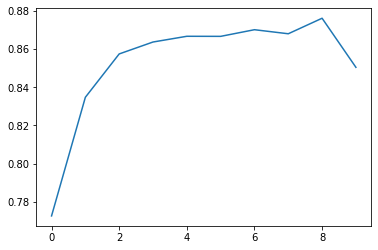

In [8]:
EMB_SIZE = 128   # embedding size
HID_SIZE = 128   # lstm hidden size
DROPOUT = 0.2 
EPOCH = 10
INITIAL_LEARNING_RATE = 1e-3

# model = LSTM_basic(MAX_WORDS, EMB_SIZE, HID_SIZE, DROPOUT).to(DEVICE)
model = LSTM_Attention(MAX_WORDS, EMB_SIZE, HID_SIZE, DROPOUT).to(DEVICE)
print(model)
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LEARNING_RATE, betas=(0.9, 0.995), eps=1e-08, weight_decay=1e-5)
best_acc = 0.0 
PATH = 'model/model.pth'  # 定义模型保存路径

acc_list = []
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH//2, eta_min=1e-8)
for epoch in range(1, EPOCH+1):  # 10个epoch
    train(model, DEVICE, train_loader, optimizer, epoch)
    acc = test(model, DEVICE, test_loader)
    acc_list.append(acc)
    if best_acc < acc: 
        best_acc = acc 
        torch.save(model.state_dict(), PATH)
    print("acc is: {:.4f}, best acc is {:.4f}\n".format(acc, best_acc)) 
    scheduler.step()
    
plt.plot(acc_list)
plt.show()

In [9]:
# 检验保存的模型
best_model = LSTM_Attention(MAX_WORDS, EMB_SIZE, HID_SIZE, DROPOUT).to(DEVICE)
best_model.load_state_dict(torch.load(PATH))
test(best_model, DEVICE, test_loader)


Test set: Average loss: 0.2961, Accuracy: 21902/25000 (88%)


0.87608

实现一个简单的Transformer
- trasnformer 对小数据集未必友好*
- 参考资料：

    [https://github.com/hyunwoongko/transformer/tree/master](https://github.com/hyunwoongko/transformer/tree/master)
    
    [https://e2eml.school/transformers.html#softmax](https://e2eml.school/transformers.html#softmax)
    
Transformer是在"Attention is all you need"神经网络中提出的神经网络模型，其结构如下图所示：
![transformer.png](./figure/transformer.png)

Transformer模型，分为左侧的Encoder和右侧的Decoder两部分，在本次实验中，由于我们只进行一个二分类的情感分析任务，因此并不需要编写太多的Decorder内容。

本实验所实现的神经网络共有以下几个部分：

- Word Embedding
- 位置编码
- Encoder实现
    - Feed Forward层
    - Add Norm层
    - Encoder block实现
    
    
## Word Embedding
Word Embedding会将一个单词转变为可以进行计算的向量，其将一个单词转映射成了低维的连续向量。如
```
cat: (-0.065, -0.035, 0.019, -0.026, 0.085,…)
dog: (-0.019, -0.076, 0.044, 0.021,0.095,…)
table: (0.027, 0.013, 0.006, -0.023, 0.014, …)
```
Word Embedding的作用是单词转变成了可以计算的向量。如：

V("King") - V("Male") +  V("Female") 约等于 V("Queen")

使用这种方式，可以使得一个单词可以作为神经网络的输入被计算。

本实验已经实现好了Word Embedding的实现。

## 位置编码

我们使用位置编码来表示单词出现在句子中的位置，由于Transformer不采用RNN的结构，而是使用全局信息，不能利用单词的顺序信息，而这部分信息对于NLP来说非常重要。所以Transformer中使用位置Embedding保存单词在序列中的相对或绝对位置。

位置编码用PE表示，PE的维度与单词Embedding是一样的。PE可以通过训练得到，也可以使用某种公式计算得到。我们在Transformer中采用了后者，其计算公式如下

$PE_{pos,2i} = sin(pos/10000^{2i/d})$

$PE_{pos,2i+1} = cos(pos/10000^{2i/d})$

其中Pos表示单词在句子中的位置，d表示PE的维度（与词Embedding一样），在此处，需要你根据公式完成对位置编码函数的实现。

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        """Please write your code here"""
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Eecoder实现
Encoder block如图所示，
![Encoder](./figure/encoder.png)
由若干个block组成，可以看到其实由Multi-Head Attention, Add & Norm, Feed Forward, Add & Norm组成的。（在本实验中，我们暂且使用单头注意力机制来代替多头注意力机制）

## Feed Forward层实现
Feed Forward层是一个两层的全连接层，第一层的激活函数为Relu，第二层不适用激活函数

In [11]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size):
        super(FeedForward, self).__init__()
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

## Add & Norm 和 Encoder Block实现
单个Encoder Block的结构如上图画红框所示, Add & Norm层由Add和Norm两部分组成，其计算公式如下：

$LayerNorm(X+SingleHeadAttention(X))$

$LayerNorm(X + FeedForward(X))$

其中X代表输入，Add是一种残差链接，通常用于解决多层网络训练的问题，而LayerNorm指的是Layer Normalization，其作用是将每一层神经元的输入都转成相同的均值和方差，此模块已经在下面的self.layer_norm定义，不需要自行编写。

**在本模块中，需要你根据Encoder的结构编写add & norm以及单个Encoder Block实现。**

In [18]:
class TransformerLayer(nn.Module):
    def __init__(self, hidden_size):
        super(TransformerLayer, self).__init__()
        self.attention = single_head_attention(hidden_size,hidden_size,dropout=0.2)
        self.feed_forward = FeedForward(hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        """Please write your code here"""

        return x
    

## Transformer结构实现
在实现了所有的基础模块后，将网络组合起来，即完成了Transformer网络的编写。

In [13]:
class MultiLayerTransformer(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers, output_size):
        super(MultiLayerTransformer, self).__init__()
        self.Embedding = nn.Embedding(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, dropout=0.1, max_len=10000)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(hidden_size) for _ in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.Embedding(x)
        x = self.positional_encoding(x)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x)
        x = F.avg_pool2d(x, (x.shape[1], 1)).squeeze()  # [bs, 1, hid_size] => [bs, hid_size]
        x = self.fc2(x)
        return x
    

开始训练与测试

MultiLayerTransformer(
  (Embedding): Embedding(10000, 128)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_layers): ModuleList(
    (0): TransformerLayer(
      (attention): single_head_attention()
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
      )
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (attention): single_head_attention()
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
      )
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Train Epoch: 1 [2304/25000 (9%)]	Loss: 0.691170
Train Epoch: 1 [4864/2

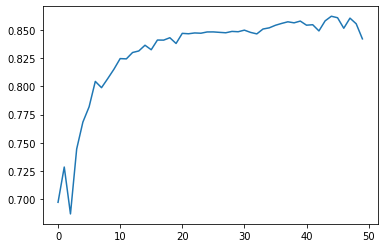

In [14]:
DEVICE = torch.device('cuda:1') #
EMB_SIZE = 128   # embedding size
HIDDEN_SIZE = 128   # embedding size
INITIAL_LEARNING_RATE = 1e-3
EPOCH = 50
trasformer = MultiLayerTransformer(input_size=MAX_WORDS, embed_size=EMB_SIZE,hidden_size=HIDDEN_SIZE, 
                              num_layers=2, output_size=2).to(DEVICE)

print(trasformer)
optimizer = optim.Adam(trasformer.parameters(), lr=INITIAL_LEARNING_RATE, 
                       betas=(0.9, 0.995), eps=1e-08, weight_decay=1e-4)
best_acc = 0.0 
PATH = 'model/transformer_model.pth'  # 定义模型保存路径

acc_list = []
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH//2, eta_min=1e-8)
for epoch in range(1, EPOCH+1):  # 10个epoch
    train(trasformer, DEVICE, train_loader, optimizer, epoch)
    acc = test(trasformer, DEVICE, test_loader)
    acc_list.append(acc)
    if best_acc < acc: 
        best_acc = acc 
        torch.save(trasformer.state_dict(), PATH)
    print("acc is: {:.4f}, best acc is {:.4f}\n".format(acc, best_acc)) 
    scheduler.step()
    
plt.plot(acc_list)
plt.show()


In [15]:
# 检验保存的模型
best_model = MultiLayerTransformer(input_size=MAX_WORDS, embed_size=EMB_SIZE,hidden_size=HIDDEN_SIZE, 
                              num_layers=2, output_size=2).to(DEVICE)
best_model.load_state_dict(torch.load(PATH))
test(best_model, DEVICE, test_loader)


Test set: Average loss: 0.3339, Accuracy: 21554/25000 (86%)


0.86216

# 作业要求

1. 按照给出的公式，完成attention函数以及single_head_attention函数
2. 对lstm + attention的超参数(Batch Size, epoch数，学习率，词向量编码长度等)进行联合调优，展示优化过程。
3. 实现一个简单的Transformer，可以进一步从以下几方面或网络结构，超参数等对结果进行改进。
    - 对位置编码进行改进
    - 将自注意力机制改为多头注意力机制
    - 对Eecoder/decoder部分进行优化
### 提交形式：pdf格式的报告，并在报告中附上源代码。